In [ ]:
#Let there be np.light
import numpy as np
import pylab as plt
import pickle as pkl
import csv
# import scipy.optimize, scipy.interpolate
import scipy.optimize as spop
import time

#Constructing fitter
def designfit(x_array,y_array, A):
    N = len(design) #number of variational parameters
    
    #Solving for fit parameters. 
    return np.linalg.solve( np.matmul(A.T,A) , np.matmul(A.T,y_array) )

# 1-D function

In [ ]:
def trial(x):
    return np.exp(-(x-0.5)**2/0.05)

xs = np.linspace(0,1,500)
data = trial(xs)
plt.plot(data)

## Using least squares (lin. alg.)

In [ ]:
design = np.array([xs**i for i in range(10)]).T
parameters = designfit(xs,data,design)
plt.plot(np.array([np.sum(sample*parameters) for sample in design]))

## Using scipy.optimize

In [ ]:
def loss2(parameters, data, design_y):
    y_hat = np.matmul(design_y,parameters)
    return np.sum((data - y_hat)**2)

initial_guess = np.ones(35)
para2 = spop.minimize(loss2,initial_guess, (data.flatten(),design))

plt.plot(np.matmul(design,para2.x))

# Defining minimizer functions

## Minimizer function (no weights, working version)

In [ ]:
def minimize2(data, P, Q, init_guess, tol, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.empty(len(init_guess[:len_y]))
    x = np.empty(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    sqerror = np.ones_like(data)
    
    counter = 0
    lsq = 1
    
    while counter < n_it:        
#     while ( lsq > tol and counter < n_it ) or counter == 1:
        counter += 1

        bQ = np.matmul(y,Q.T)
        M = np.matmul( np.matmul(P.T,np.diag(bQ)**2), P )
        v = np.matmul( P.T, z*bQ ) 
        x[:] = np.linalg.solve(M,v)[:]
        
        aP = np.matmul(x,P.T)
        M = np.matmul( np.matmul(Q.T,np.diag(aP)**2), Q )
        v = np.matmul( Q.T, z*aP )
        y[:] = np.linalg.solve(M,v)[:]
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Minimizer function (with weights)

In [ ]:
def remove_zeros(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = 0.000000000001
#     flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize3(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.zeros(len(init_guess[:len_y]))
    x = np.zeros(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    inv_sqerror = np.ones_like(data.flatten())
    
    counter = 0
    lsq = 1
    
    while counter < n_it or counter == 1:        
        counter += 1
        
        # Solving f(x) parameters
        bQ = np.matmul(y,Q.T)
        M = np.matmul( np.matmul(P.T,np.diag(inv_sqerror*bQ**2)), P )
        v = np.matmul( P.T, z*inv_sqerror*bQ ) 
        x[:] = np.linalg.solve(M,v)[:]
        
        # Solving g(y) parameters
        aP = np.matmul(x,P.T)
        M = np.matmul( np.matmul(Q.T,np.diag(inv_sqerror*aP**2)), Q )
        v = np.matmul( Q.T, z*inv_sqerror*aP )
        y[:] = np.linalg.solve(M,v)[:]
        
        # Updating squared error matrix; removing zeroes
        y_hat = np.matmul(design_y,y)
        x_hat = np.matmul(design_x,x)        
        inv_sqerror = 1/remove_zeros(np.abs(z - y_hat*x_hat))

        # Normalizing g(y) parameters
        y[:] = y[:]/np.max(y_hat)
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

# Outer product (polyfits: x - 11, y - 3); Gaussian x 1

## Sample data

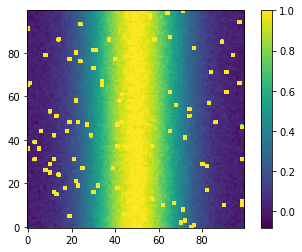

In [66]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
#    return 1*(np.sin(yy))**2*np.exp(-(xx-0.5)**2/0.05)
    return np.exp(-(xx-0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 1000*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=1)
plt.colorbar()
plt.show()

## Modelling sample data (iterative lin. alg.)

In [67]:
# Making design matrices

## Vectorizing field sample points
xxs, yys = np.meshgrid(xs,ys)

xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

x_len = 11
y_len = 3

design_x = np.array([xxs_flat**i for i in range(x_len)]).T
design_y = np.array([yys_flat**i for i in range(y_len)]).T
# parameters = designfit(ys,data_sim[:,50],design)
# plt.plot(np.array([np.sum(sample*parameters) for sample in design]))

initial_guess = np.ones(y_len+x_len)
# initial_guess[-1] = 0.0001
guess = minimize3(data_sim, design_x, design_y, initial_guess, 6, y_len)

1
2
3
4
5
6
Time elapsed is 5.8747718334198. Iterations: 6.


Function in x:


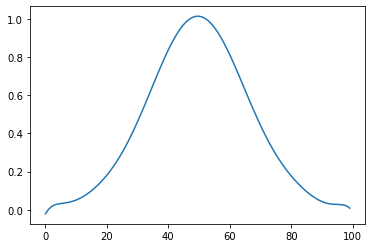

Function in y:


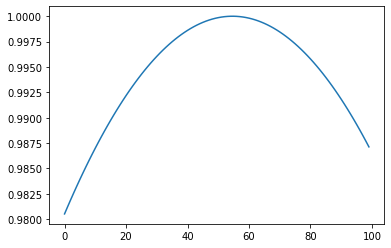

2-D plot


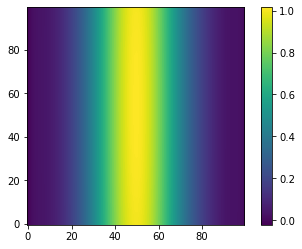

In [68]:
design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(x_len)]).T

print('Function in x:')
plt.plot(np.matmul(design_x_test,guess[1]))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,guess[0]))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

## Using scipy.optimize

In [ ]:
y_len = 4

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(11)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(11)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(11+y_len)

start_time = time.time()
guess2 = spop.minimize(loss,initial_guess, (data_sim.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess2.x[:y_len]
a_para = guess2.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()

# Outer product (polyfits: x - 11, y - 35); Gaussian x Sine

## Sample data

In [ ]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return 1*(np.sin(yy*10))**2*np.exp(-(xx-0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (3/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim2 = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 1000*cosmic_rays

plt.imshow(data_sim2, origin='lower', vmax=2)
plt.show()

## Modelling data (iterative lin. alg.)

In [64]:
xxs, yys = np.meshgrid(xs,ys)

xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

design_x = np.array([xxs_flat**i for i in range(11)]).T
design_y = np.array([yys_flat**i for i in range(35)]).T

initial_guess = np.ones(11+35)

guess = minimize3(data_sim2, design_x, design_y, initial_guess, 6, 35)

1
2
3
4
5
6
Time elapsed is 7.431334018707275. Iterations: 6.


Function in x:


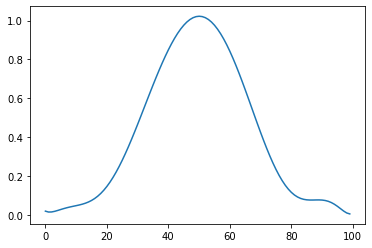

Function in y:


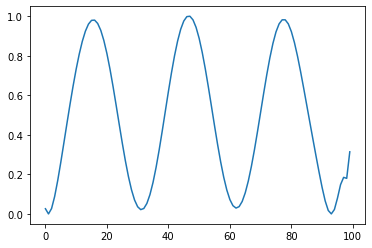

2-D plot


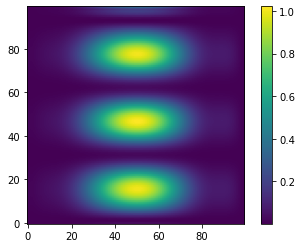

In [65]:
design_y_test = np.array([ys**i for i in range(35)]).T
design_x_test = np.array([xs**i for i in range(11)]).T

print('Function in x:')
plt.plot(np.matmul(design_x_test,guess[1]))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,guess[0]))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

## Using sines and cosines

In [ ]:
xxs, yys = np.meshgrid(xs,ys)

xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

design_x = np.array([xxs_flat**i for i in range(11)]).T
design_y = np.array([yys_flat**i for i in range(35)]).T

In [122]:
xxs

array([[0.        , 0.01010101, 0.02020202, ..., 0.97979798, 0.98989899,
        1.        ],
       [0.        , 0.01010101, 0.02020202, ..., 0.97979798, 0.98989899,
        1.        ],
       [0.        , 0.01010101, 0.02020202, ..., 0.97979798, 0.98989899,
        1.        ],
       ...,
       [0.        , 0.01010101, 0.02020202, ..., 0.97979798, 0.98989899,
        1.        ],
       [0.        , 0.01010101, 0.02020202, ..., 0.97979798, 0.98989899,
        1.        ],
       [0.        , 0.01010101, 0.02020202, ..., 0.97979798, 0.98989899,
        1.        ]])

In [280]:
def fourier_design(x_array, n_freq):
    'In (column) list, cosines followed sines.'
    assert 2*n_freq < len(x_array)
    
    L = np.max(x_array) - np.min(x_array)
    k0 = 2*np.pi/L
    
    output_cos = [np.cos(k0*i*x_array) for i in range(n_freq)]
    output_sin = [np.sin(k0*i*x_array) for i in range(n_freq)]
    
    return np.concatenate((output_cos, output_sin)).T

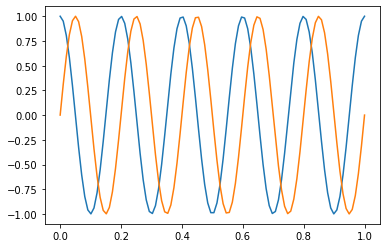

In [281]:
# Testing Fourier design matrix

index = 5
n_freqs = 10
test1 = np.column_stack((xxs_flat,fourier_design(xxs_flat,n_freqs)[:,index]))
test1 = test1[np.argsort(test1[:,0])]
test2 = np.column_stack((xxs_flat,fourier_design(xxs_flat,n_freqs)[:,n_freqs+index]))
test2 = test2[np.argsort(test2[:,0])]
plt.plot(test1[:,0], test1[:,1],)
plt.plot(test2[:,0], test2[:,1])

## Using scipy

In [ ]:
y_len = 35
x_len = 35

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(x_len)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(x_len)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(x_len+y_len)

start_time = time.time()
guess2 = spop.minimize(loss,initial_guess, (data_sim2.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess2.x[:y_len]
a_para = guess2.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

# Outer product (polyfits: x - 11, y - 35); Sine x 1

In [ ]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return (np.sin(xx*10))**2

data_clean = f(ys,xs)
cosmic_rays = 100*0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim3 = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 0*cosmic_rays

plt.imshow(data_sim3, origin='lower')
plt.show()

In [ ]:
y_len = 11
x_len = 35

xxs, yys = np.meshgrid(xs,ys)

xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(x_len)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(x_len)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(x_len+y_len)

start_time = time.time()
guess3 = spop.minimize(loss,initial_guess, (data_sim3.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess3.x[:y_len]
a_para = guess3.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

# Outer product (polyfits: x - 11, y - 35); Gaussian x Gaussian

In [ ]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
#     return (np.exp(-(yy-0.8)**2/0.05) + np.exp(-(yy-0.2)**2/0.05) )*np.exp(-(xx-0.5)**2/0.05)
#     return np.cos(2*np.pi*yy/(1))**2*np.exp(-(xx-0.5)**2/0.05)
    return (np.exp(-(yy-0.25)**2/0.05)+np.exp(-(yy-0.75)**2/0.05))*np.exp(-(xx-0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 100*0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim3 = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 0*cosmic_rays

plt.imshow(data_sim3, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
x_len = 11
y_len = 22

xxs, yys = np.meshgrid(xs,ys)

xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(x_len)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(x_len)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(x_len+y_len)

start_time = time.time()
guess2 = spop.minimize(loss,initial_guess, (data_sim3.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess2.x[:y_len]
a_para = guess2.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()